In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    # There is no tf.pi so we wrap np.pi as a TF constant
    learning_rate = 0.5 * target_lr * (1 + tf.cos(tf.constant(np.pi) * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = tf.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)
    
    learning_rate = tf.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate

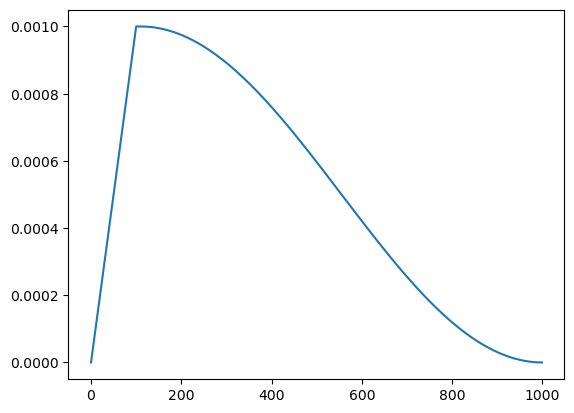

In [4]:
steps = np.arange(0, 1000, 1)
lrs = []

for step in steps:
  lrs.append(lr_warmup_cosine_decay(step, total_steps=len(steps), warmup_steps=100, hold=10))
plt.plot(lrs)

In [5]:
class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_steps, total_steps, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold
        )

        return tf.where(
            step > self.total_steps, 0.0, lr, name="learning_rate"
        )